# Retrieving and formating the data

In [1]:
# Step 1: Install Required Libraries
#!python -m venv .venv
!pip install transformers datasets scikit-learn pandas tqdm -q
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu114
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platfo

In [1]:
# Step 2: Download and Extract the IMDb Dataset
import os
import tarfile
import urllib.request
import torch
from torch.utils.data import DataLoader

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()
    print("Dataset downloaded and extracted.")

In [2]:
# Extraction des données, version avec les ratings (+ urls si besoin)
import glob
import pandas as pd

def create_datasets(dataset_type, polarity, base_path="aclImdb"):
    """
    Charge les reviews et les URLs correspondantes à partir des fichiers.
    
    :param dataset_type: 'train' ou 'test'
    :param polarity: 'pos' ou 'neg'
    :param base_path: Chemin de base vers les données (par défaut: "dossier_de_sortie/aclImdb")
    :return: DataFrame fusionné contenant les avis, les notes et les URLs associées
    """
    # chemins d'accès
    review_path = os.path.join(base_path, dataset_type, polarity)
    url_file = os.path.join(base_path, dataset_type, f"urls_{polarity}.txt")
    
    # Loading review files into a list
    data = []
    for filepath in glob.glob(os.path.join(review_path, "*.txt")):
        with open(filepath, "r", encoding="utf-8") as f:
            review_text = f.read()
        review_id, rating = os.path.basename(filepath).replace(".txt", "").split("_")
        label = 1 if polarity == "pos" else 0
        data.append((review_id, review_text, rating, label))
    
    # Create DataFrame for the reviews
    df_reviews = pd.DataFrame(data, columns=["id_review", "review", "rating", "label"])

    # Load URLs file
    df_urls = pd.read_csv(url_file, header=None, names=['url'])
    df_urls['id_review'] = df_urls.index
    df_reviews['id_review'] = df_reviews['id_review'].astype(int)
    df_urls['id_review'] = df_urls['id_review'].astype(int)
    
    # Merge review data with URL data
    merged_df = pd.merge(df_reviews, df_urls, on="id_review", how="inner")
    
    return merged_df

# Load the datasets
merged_train_neg = create_datasets(dataset_type="train", polarity="neg")
merged_train_pos = create_datasets(dataset_type="train", polarity="pos")
merged_test_neg = create_datasets(dataset_type="test", polarity="neg")
merged_test_pos = create_datasets(dataset_type="test", polarity="pos")

In [3]:
merged_train_neg.head()

,id_review,review,rating,label,url
0,7639,I saw this film at the NY Gay & Lesbian Film F...,1,0,http://www.imdb.com/title/tt0306761/usercomments
1,2824,"I'm a big Porsche fan, and the car was the bes...",2,0,http://www.imdb.com/title/tt0099462/usercomments
2,11392,"For years I remember reading about this show ""...",1,0,http://www.imdb.com/title/tt0199278/usercomments
3,11186,"I wanted to watch this movie, but one bizarre ...",2,0,http://www.imdb.com/title/tt0304711/usercomments
4,4161,"A stuttering plot, uninteresting characters an...",1,0,http://www.imdb.com/title/tt0338963/usercomments


In [13]:
merged_train_neg.columns

Index(['id_review', 'review', 'rating', 'label', 'url'], dtype='object')

In [14]:
print(len(pd.unique(merged_test_neg['url']))) # nombre de films dans la moitié négative de la base test
len(merged_test_neg) # nombre de reviews

3016


12500

In [5]:
test = pd.concat([merged_test_pos, merged_test_neg], ignore_index=True)
train = pd.concat([merged_train_pos, merged_train_neg], ignore_index=True)

In [6]:
# version shuffled
test_df = test.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train.sample(frac=1, random_state=42).reset_index(drop=True)
test_df.head()

,id_review,review,rating,label,url
0,7719,My comment is mainly a comment on the first co...,7,1,http://www.imdb.com/title/tt0449000/usercomments
1,7037,"Although I have rarely flown myself, I am keen...",3,0,http://www.imdb.com/title/tt0127557/usercomments
2,8213,At last!! Sandra Bullock is indeed a beautiful...,10,1,http://www.imdb.com/title/tt0113957/usercomments
3,3680,If they had a Zero out of 10 I would of entere...,1,0,http://www.imdb.com/title/tt0488164/usercomments
4,1899,What a frustrating movie. A small Southern tow...,2,0,http://www.imdb.com/title/tt0098383/usercomments


In [ ]:
# NOUVEAU : on enlève le langage HTML
import re

def remove_html_tags(text):
    """
    Remove HTML tags from the input text using regular expressions.
    """
    clean_text = re.sub(r'<.*?>', '', text)  # Remove any HTML tag (e.g., <br>, <div>, <p>, etc.)
    return clean_text

# Apply the cleaning function to your dataset
test_df["review"] = test_df["review"].apply(remove_html_tags)
train_df["review"] = train_df["review"].apply(remove_html_tags)

In [7]:
# Step 4: Convert to HuggingFace Dataset Format
from datasets import Dataset
from sklearn.model_selection import train_test_split

# 1. Split train_df into train and eval sets
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    train_df["review"].tolist(),
    train_df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

# 2. Create Dataset objects
train_dataset = Dataset.from_dict({"review": train_texts, "label": train_labels})
eval_dataset = Dataset.from_dict({"review": eval_texts, "label": eval_labels})
test_dataset = Dataset.from_pandas(test_df)

# PART I : Training and evaluating a BERT model

In [8]:
# Bert pour tokeniser + train
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

2025-04-27 15:47:05.094740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745768825.272926     195 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745768825.323899     195 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Gestion des reviews trop longues : la fonction (certainement pas optimisée) ci-dessous coupe les versions tokenisées trop 
# longues (+510 tokens) en prenant les 128 premiers tokens et les 382 derniers (selon le papier : https://arxiv.org/pdf/1905.05583)

def tokenize_and_process(batch):
    # Step 1: Tokenize the text without padding or special tokens
    tokenized = tokenizer(batch["review"], padding=False, truncation=False, is_split_into_words=False)

    # Step 2: Compute the number of tokens for each review before truncation
    num_tokens = [len(t) for t in tokenized["input_ids"]]

    # Step 3: Truncate the tokens if the sequence length exceeds 512 tokens
    truncated_input_ids = []
    for t in tokenized["input_ids"]:
        if len(t) > 510:
            # Keep first 128 and last 382 tokens (this is the truncation logic)
            truncated_input_ids.append(t[:128] + t[-382:])
        else:
            # Keep the entire sequence if it's less than or equal to 512 tokens
            truncated_input_ids.append(t)
    
    # Step 4: Now we will manually pad to 512 tokens (if it's shorter than 512)
    max_length = 510
    padded_input_ids = []
    attention_mask = []

    for t in truncated_input_ids:
        # Manually pad to 512 tokens (if necessary)
        padding_length = max_length - len(t)
        padded_input_ids.append(t + [tokenizer.pad_token_id] * padding_length)
        attention_mask.append([1] * len(t) + [0] * padding_length)

    # Step 5: Add special tokens manually
    # For BERT, the special tokens are [CLS] and [SEP] at the start and end of the sequence
    cls_token_id = tokenizer.cls_token_id
    sep_token_id = tokenizer.sep_token_id

    final_input_ids = []
    final_attention_mask = []

    for i in range(len(padded_input_ids)):
        # Add [CLS] token at the start and [SEP] token at the end
        final_input_ids.append([cls_token_id] + padded_input_ids[i] + [sep_token_id])
        final_attention_mask.append([1] + attention_mask[i] + [1])  # 1 for actual tokens, 1 for [CLS] and [SEP]

    # Step 6: Now return the final batch with `input_ids`, `attention_mask`, and `num_tokens`
    final_batch = {
        "input_ids": torch.tensor(final_input_ids),
        "attention_mask": torch.tensor(final_attention_mask),
        "label": torch.tensor(batch["label"]),  # Assuming labels exist in the batch
        "num_tokens": torch.tensor(num_tokens)
    }

    return final_batch

# Apply the function to the datasets
train_tokenized = train_dataset.map(tokenize_and_process, batched=True)
eval_tokenized = eval_dataset.map(tokenize_and_process, batched=True)
test_tokenized = test_dataset.map(tokenize_and_process, batched=True)

# Set the format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [21]:
eval_tokenized['input_ids'].shape

torch.Size([5000, 512])

In [22]:
import transformers
print(transformers.__version__)

4.51.1


In [23]:
# Step 7: Load BERT and Trainer
from transformers import Trainer, TrainingArguments, TrainerCallback
from sklearn.metrics import accuracy_score
import accelerate
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device:", device)

# Custom compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

class MyCallback(TrainerCallback):
    def __init__(self, trainer, eval_steps=500):
        self.trainer = trainer  # Save the trainer reference
        self.eval_steps = eval_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.eval_steps == 0:
            print(f"\nEvaluating at step {state.global_step}...")
            self.trainer.evaluate()


# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate=5e-5,  
    num_train_epochs=2,  
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    logging_steps=500,  
    logging_dir="./logs", 
    save_strategy="no"
)


# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,  
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 

my_callback = MyCallback(trainer=trainer, eval_steps=500)

# Finally, add the callback to the trainer
trainer.add_callback(my_callback)


Training on device: cuda


/tmp/ipykernel_31/2931674997.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
# Step 8: Fine-Tune BERT
import wandb
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paul-d10 (paul-d10-ensae-alumni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Accuracy
500,No log,0.241281,0.919800
1000,No log,0.245937,0.913200
1500,No log,0.258428,0.932800
2000,No log,0.232135,0.938600
2500,No log,0.217144,0.945000



Evaluating at step 500...

Evaluating at step 1000...

Evaluating at step 1500...

Evaluating at step 2000...

Evaluating at step 2500...


TrainOutput(global_step=2500, training_loss=0.19413853759765626, metrics={'train_runtime': 2902.5127, 'train_samples_per_second': 13.781, 'train_steps_per_second': 0.861, 'total_flos': 1.05244422144e+16, 'train_loss': 0.19413853759765626, 'epoch': 2.0})

In [25]:
# Save model after training
model_save_path = "./imdb_sentiment_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Save training arguments using the to_json_string method instead
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model


In [10]:
# Pour reload le modèle, pas besoin normalement
from torch.utils.data import DataLoader

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model_save_path = "./imdb_sentiment_model" 
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Step 9: Predict Scores for Test Set
from tqdm import tqdm

test_loader = DataLoader(test_tokenized, batch_size=16)
model.eval()

all_texts = test_df["review"].tolist()
all_true_labels = test_df["label"].tolist()
all_ratings = test_df["rating"].tolist()
all_preds = []
all_scores = []
all_token_counts = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # Positive class score
        all_token_counts.extend(batch["num_tokens"].cpu().numpy())  # Original token count


100%|██████████| 1563/1563 [06:20<00:00,  4.10it/s]


In [ ]:
# Step 9: Predict Scores for Test Set and get the embeddings for all tokens => NE PAS EXECUTER, PB DE MEMOIRE A REGLER D'ABORD
from tqdm import tqdm

test_loader = DataLoader(test_tokenized, batch_size=16)
model.eval()

all_texts = test_df["review"].tolist()
all_true_labels = test_df["label"].tolist()
all_ratings = test_df["rating"].tolist()
all_preds = []
all_scores = []
all_token_counts = []

all_token_embeddings = []
all_attention_masks = []
all_input_ids = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # Positive class score
        all_token_counts.extend(batch["num_tokens"].cpu().numpy())  # Original token count

        last_hidden_state = outputs.hidden_states[-1]  # Take the last layer
        all_token_embeddings.append(last_hidden_state.cpu())
        all_attention_masks.append(attention_mask.cpu())
        all_input_ids.append(input_ids.cpu())

all_token_embeddings = torch.cat(all_token_embeddings, dim=0)  # (num_samples, seq_len, hidden_size)
all_attention_masks = torch.cat(all_attention_masks, dim=0)    # (num_samples, seq_len)
all_input_ids = torch.cat(all_input_ids, dim=0)                # (num_samples, seq_len)

 73%|███████▎  | 1136/1563 [05:06<04:34,  1.56it/s]

In [12]:
# Step 10: Create Final Scored DataFrame
import numpy as np

# Final DataFrame
scored_df = pd.DataFrame({
    "review": all_texts,
    "true_label": all_true_labels,
    "rating": all_ratings,
    "predicted_label": all_preds,
    "positive_score": all_scores,
    "num_tokens": all_token_counts
})

scored_df["rating"] = scored_df["rating"].astype(int)

# Adding a 'confidence' column
scored_df["confidence"] = np.where(scored_df["predicted_label"] == 1, scored_df["positive_score"], 1 - scored_df["positive_score"])

# Optional: Add "was_truncated" flag (if > 512 tokens)
scored_df["was_truncated"] = scored_df["num_tokens"] > 512

scored_df.head()

scored_df.to_csv('predictions_full_results.csv', index=False)

np.save("preds.npy", np.array(all_preds))
np.save("scores.npy", np.array(all_scores))
print(f"Predictions and scores saved.")

Predictions and scores saved.


In [13]:
# Step 11 : Compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(scored_df["true_label"], scored_df["predicted_label"])
precision, recall, f1, _ = precision_recall_fscore_support(scored_df["true_label"], scored_df["predicted_label"], average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9424
Precision: 0.9377
Recall: 0.9477
F1 Score: 0.9427


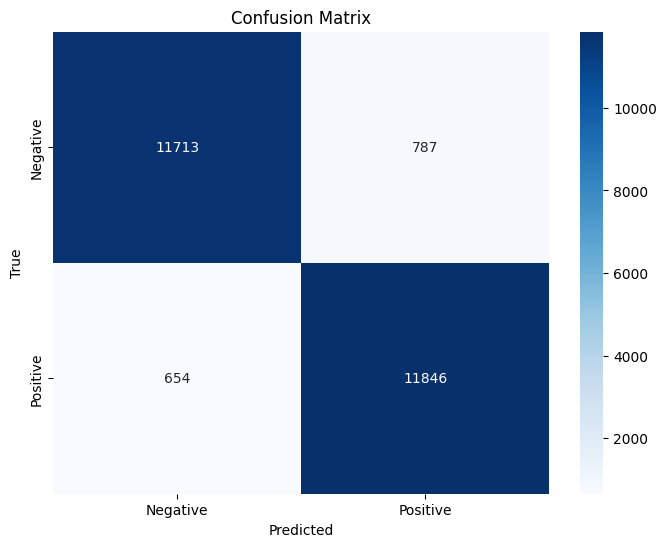

In [14]:
# Create confusion matrix
cm = confusion_matrix(scored_df["true_label"], scored_df["predicted_label"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Plot some examples of predictions (whole dataset)
def show_example_predictions(df, num_examples=10):
    indices = np.random.choice(df.index, min(num_examples, len(df)), replace=False)

    for idx in indices:
        review = df.loc[idx, "review"]
        true_label = "Positive" if df.loc[idx, "true_label"] == 1 else "Negative"
        pred_label = "Positive" if df.loc[idx, "predicted_label"] == 1 else "Negative"
        positive_score = df.loc[idx, "positive_score"]
        confidence = df.loc[idx, "confidence"]
        num_tokens = df.loc[idx, "num_tokens"]
        
        print(f"Index: {idx}") 
        print(f"Review (first 200 chars): {review[:200]}...")
        print(f"True Sentiment: {true_label}")
        print(f"Predicted Sentiment: {pred_label} (Confidence: {confidence:.4f})")
        print(f"Positive Score: {positive_score:.4f}")
        print(f"Number of tokens: {num_tokens}")
        print("-" * 80)

show_example_predictions(scored_df, num_examples=10)

Index: 16633
Review (first 200 chars): I just got the DVD for Hardware Wars, in a shiny new package, looking irresistable. Stuck it in my DVD player to find a slew of extra fun stuff. The extra content on the DVD is even longer than the mo...
True Sentiment: Positive
Predicted Sentiment: Positive (Confidence: 0.9939)
Positive Score: 0.9939
Number of tokens: 295
--------------------------------------------------------------------------------
Index: 4660
Review (first 200 chars): The sound in this movie is a nightmare. That is the best I can say for this movie. Any chance of a good story is lost once this films starts. The premise of the film sounds good. A playboy who comes t...
True Sentiment: Negative
Predicted Sentiment: Negative (Confidence: 0.9989)
Positive Score: 0.0011
Number of tokens: 156
--------------------------------------------------------------------------------
Index: 5366
Review (first 200 chars): I thought this was a very good movie. Someone said it was 'sick' so they 

In [16]:
# Focus on incorrect predictions
incorrect_df = scored_df[scored_df["predicted_label"] != scored_df["true_label"]]
correct_df = scored_df[scored_df["predicted_label"] == scored_df["true_label"]]

# Showing some examples of incorrect predictions
show_example_predictions(incorrect_df, num_examples = 20)

Index: 3512
Review (first 200 chars): When I attended college in the early 70s, it was a simpler time. Except for a brief occurrence in 1994, I've been totally free of the influence of illegal substances ever since and I've never regrette...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9919)
Positive Score: 0.9919
Number of tokens: 385
--------------------------------------------------------------------------------
Index: 4269
Review (first 200 chars): I don't usually like TV movies, I reckon that if the thing was any good it would make it to Hollywood. This one though is better than average, pretty high production values, a few interesting story tw...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9969)
Positive Score: 0.9969
Number of tokens: 60
--------------------------------------------------------------------------------
Index: 217
Review (first 200 chars): Clayton Moore made his last official appearance on screen as the Masked Man 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


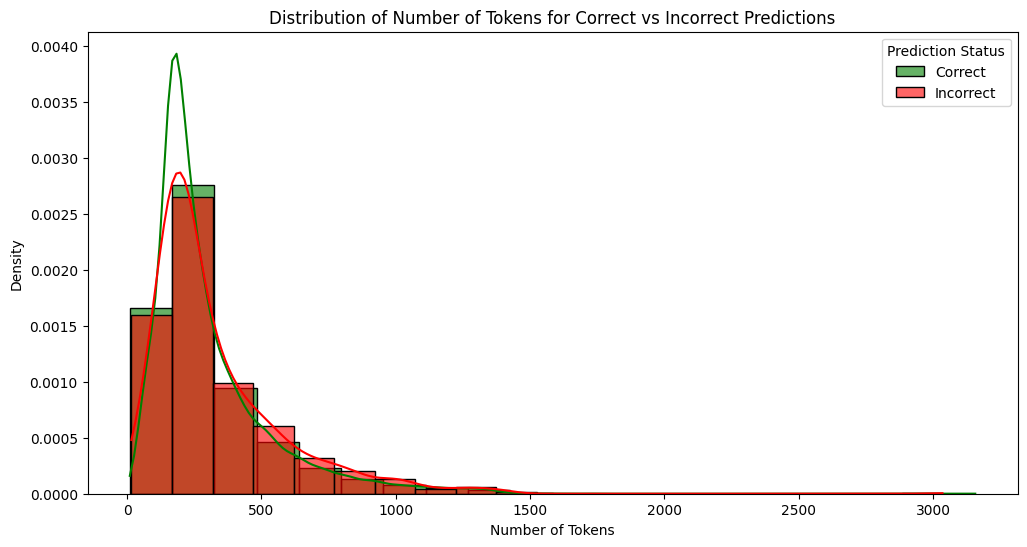

In [17]:
# Plot the distributions using seaborn
plt.figure(figsize=(12, 6))

# Correct tokens distribution
sns.histplot(correct_df["num_tokens"], color='green', label='Correct', kde=True, stat="density", bins=20, alpha=0.6)

# Incorrect tokens distribution
sns.histplot(incorrect_df["num_tokens"], color='red', label='Incorrect', kde=True, stat="density", bins=20, alpha=0.6)

plt.title("Distribution of Number of Tokens for Correct vs Incorrect Predictions")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.legend(title="Prediction Status")
plt.show()

In [18]:
# Calculate proportions of reviews with 'was_truncated' as True
correct_over_512_proportion = len(correct_df[correct_df["was_truncated"] == True]) / len(correct_df)
incorrect_over_512_proportion = len(incorrect_df[incorrect_df["was_truncated"] == True]) / len(incorrect_df)

# Print the proportions
print(f"Proportion of correctly classified reviews with over 512 tokens: {correct_over_512_proportion:.4f}")
print(f"Proportion of incorrectly classified reviews with over 512 tokens: {incorrect_over_512_proportion:.4f}")

Proportion of correctly classified reviews with over 512 tokens: 0.1383
Proportion of incorrectly classified reviews with over 512 tokens: 0.1770


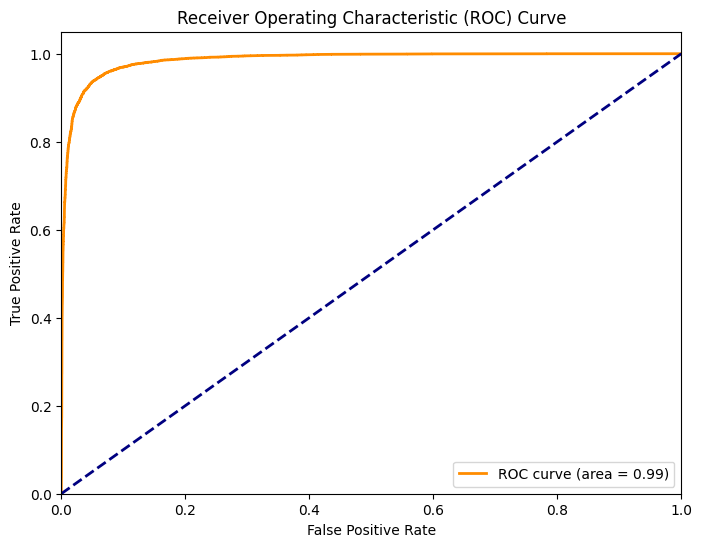

In [19]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# Step 1: Get true labels and predicted probabilities
# True labels are in 'true_label' column
labels = scored_df["true_label"].values

# Predicted probabilities for the positive class are in 'positive_score' column
# Since we already have the probabilities, no need to apply softmax again.
probs = scored_df["positive_score"].values

# Step 2: Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# PART II : using LIME to further analyze the results

In [20]:
!pip install lime

In [21]:
# Importing the necessary library and create an empty cache
from lime.lime_text import LimeTextExplainer
import gc
import joblib
from collections import Counter

torch.cuda.empty_cache()

lime_cache_file = "lime_cache.pkl"
try:
    lime_cache = joblib.load(lime_cache_file)
    print(f"Loaded {len(lime_cache)} cached explanations")
except:
    lime_cache = {}
    print("Created new LIME explanation cache")

Created new LIME explanation cache


In [22]:
# Loading our fine-tuned model and tokenizer
model_save_path = "./imdb_sentiment_model"  # Path where we saved the model
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Moving model to the right device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setting model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
# Function necessary in LIME explanation, to get the probabilities for the positive class
def predict_proba_lime(texts):
    # Ensure the model is on CPU for LIME predictions
    model_cpu = model.to("cpu")
    
    # Process inputs in smaller batches
    batch_size = 8
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Reduce max_length to save memory (e.g., 256 tokens)
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                         return_tensors="pt", max_length=256)
        
        with torch.no_grad():
            outputs = model_cpu(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.numpy())
    
    return np.vstack(all_probs) if len(all_probs) > 1 else all_probs[0]

In [24]:
# Define the LIME explainer
class_names = ["Negative", "Positive"]
explainer = LimeTextExplainer(class_names=class_names, split_expression='\W+')

# Function to get or compute LIME explanation
def get_or_compute_explanation(idx, num_features=5):
    cache_key = f"{idx}_{num_features}"
    if cache_key in lime_cache:
        return lime_cache[cache_key]
    
    # Get the text from the dataframe
    text = scored_df.loc[idx,'review']
    
    # Generate LIME explanation with reduced samples
    explanation = explainer.explain_instance(
        text,
        predict_proba_lime,
        num_features=min(num_features, len(text.split())),
        num_samples=500,  # Reduced from default 5000 to save memory
        top_labels=2
    )
    
    # Cache the result
    lime_cache[cache_key] = explanation
    if len(lime_cache) % 5 == 0:  # Save cache periodically
        joblib.dump(lime_cache, lime_cache_file)
    
    return explanation

In [26]:
# Function to analyze a specific misclassified example
def analyze_classification(idx, num_features=5):
    # Move model to CPU and clear memory
    model.to("cpu")
    torch.cuda.empty_cache()
    gc.collect()

    text = scored_df.loc[idx, 'review'] #voir si redondance à corriger ?
    
    print(f"\n{'='*80}")
    print(f"ANALYZING THE EXAMPLE #{idx}")
    print(f"{'='*80}")
    show_example_predictions(scored_df.loc[[idx]], num_examples=1)
    print("-" * 80)
   
    # Get explanation (from cache or compute new)
    explanation = get_or_compute_explanation(idx, num_features)

    # Analyze both classes to understand why the misclassification happened
    for label_id in [0, 1]:  # 0: Negative, 1: Positive
        label_name = class_names[label_id]
        print(f"\nFeature importance for class: {label_name}")

        # Get the words and their weights
        feature_importance = explanation.as_list(label_id)

        # Sort by absolute weight for better visualization
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

        # Text-based visualization instead of matplotlib
        print(f"Top words driving {label_name} prediction:")
        for word, weight in feature_importance[:10]:
            impact = "increasing" if weight > 0 else "decreasing"
            print(f"  • '{word}': {weight:.4f} ({impact} probability)")

    # Identify words in context
    print("\nWords in context:")
    for word, _ in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:5]:
        # Simple approach to find word in context (not perfect for subwords)
        lower_text = text.lower()
        word_lower = word.lower()
        start_pos = lower_text.find(word_lower)
        if start_pos != -1:
            # Get some context around the word
            context_start = max(0, start_pos - 50)
            context_end = min(len(text), start_pos + len(word) + 50)

            context = text[context_start:context_end]
            # Highlight the word in the context
            highlighted = context.replace(word, f"**{word}**")
            print(f"  • Context: \"...{highlighted}...\"")

    # Clear memory again
    torch.cuda.empty_cache()
    gc.collect()
    
    return explanation

In [27]:
# Batch processing for misclassifications
def analyze_misclassifications_batch(num_examples=3, batch_size=2):
    # Ensure correct indices are selected from the incorrect_df
    indices = np.random.choice(incorrect_df.index, min(num_examples, len(incorrect_df)), replace=False)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_classification(idx)  # Analyze the example using the correct index from scored_df
        
        # Clear memory after each batch
        model.to("cpu")
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Completed batch {i//batch_size + 1}/{(len(indices) + batch_size - 1)//batch_size}")


In [28]:
def analyze_confident_misclassifications(num_examples=3, batch_size=2):
    if incorrect_df.empty:
        print("No misclassified examples found.")
        return

    # Get the top 100 most confident incorrect predictions
    top_incorrect = incorrect_df.sort_values(by="confidence", ascending=False).head(100)

    # Then pick the most confident among them
    selected_indices = top_incorrect.index[:num_examples]

    # Analyze in batches
    print(f"\n{'='*80}")
    print(f"ANALYZING MOST CONFIDENT MISCLASSIFICATIONS")
    print(f"{'='*80}")

    for i in range(0, len(selected_indices), batch_size):
        batch_indices = selected_indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_classification(idx)
        
        # Clear memory after each batch
        torch.cuda.empty_cache()
        gc.collect()


In [29]:
def analyze_misclassification_patterns(max_examples=20):
    if incorrect_df.empty:
        print("No misclassified examples found.")
        return

    word_frequency = Counter()

    # Limit examples
    for idx in incorrect_df.index[:max_examples]:
        text = incorrect_df.loc[idx, 'review']
        words = set(text.lower().split())
        word_frequency.update(words)

    print("\nCommon words in misclassified examples:")
    for word, count in word_frequency.most_common(10):
        if len(word) > 2:
            print(f"'{word}': {count}")

    print("\nPotentially problematic words:")
    for word, count in word_frequency.most_common(50):
        if len(word) > 3 and count > max_examples / 3:
            examples = []
            for idx in incorrect_df.index[:max_examples]:
                text = incorrect_df.loc[idx, 'review'].lower()
                if word in text.split():
                    true_label = "Positive" if incorrect_df.loc[idx, 'true_label'] == 1 else "Negative"
                    pred_label = "Positive" if incorrect_df.loc[idx, 'predicted_label'] == 1 else "Negative"
                    examples.append((true_label, pred_label))
                    if len(examples) >= 3:
                        break
            if examples:
                print(f"'{word}': {count} occurrences - Examples: {examples}")


In [30]:
# Run the analysis with improved memory management
print("Starting optimized LIME analysis of misclassified examples...")
analyze_misclassifications_batch(3, batch_size=1)  # Analyze 3 random misclassifications, 1 at a time

print("\nAnalyzing patterns in misclassifications...")
analyze_misclassification_patterns(20)

print("\nAnalyzing the most confident misclassifications...")
analyze_confident_misclassifications(3, batch_size=1)  # Analyze 3 most confident misclassifications, 1 at a time

# Save final cache
joblib.dump(lime_cache, lime_cache_file)
print(f"\nSaved {len(lime_cache)} explanations to cache")

Starting optimized LIME analysis of misclassified examples...

ANALYZING THE EXAMPLE #12653
Index: 12653
Review (first 200 chars): Although this was the first Hunter S. Thompson documentary I have seen it was average at best despite the involvement's of huge star appearances such as Johnny Depp, Bill Murray, Gary Busey, and a few...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9650)
Positive Score: 0.9650
Number of tokens: 146
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Feature importance for class: Negative
Top words driving Negative prediction:
  • 'still': -0.3087 (decreasing probability)
  • 'a': -0.2953 (decreasing probability)
  • 'little': 0.1680 (increasing probability)
  • 'Not': 0.1601 (increasing probability)
  • 'let': 0.1546 (increasing probability)

Feature importance for class: Positive
Top words driving Positive prediction:
  • 

# PART III : Embeddings

Non faisable tant que le problème de mémoire n'est pas réglé

In [ ]:
import torch
import torch.nn.functional as F

# Step 1: Find misclassified and correctly classified examples with 'masterpiece'
misclassified_with_word = incorrect_df[incorrect_df["review"].str.contains(r"\bmasterpiece\b", case=False, regex=True)]
correct_with_word = correct_df[correct_df["review"].str.contains(r"\bmasterpiece\b", case=False, regex=True)]

# Pick one example from each
mis_idx = misclassified_with_word.index[0]
correct_idx = correct_with_word.index[0]

print(f"Misclassified index: {mis_idx}, Correctly classified index: {correct_idx}")

# Step 2: Get their embeddings
# (all_token_embeddings shape = (num_reviews, 512, 768))
mis_embeddings = all_token_embeddings[mis_idx]      # (512, 768)
correct_embeddings = all_token_embeddings[correct_idx]  # (512, 768)

# Step 3: Find the token position of 'masterpiece' in input_ids
# (all_input_ids shape = (num_reviews, 512))
mis_input_ids = all_input_ids[mis_idx]
correct_input_ids = all_input_ids[correct_idx]

# Decode tokens to strings (optional step for checking)
mis_tokens = tokenizer.convert_ids_to_tokens(mis_input_ids)
correct_tokens = tokenizer.convert_ids_to_tokens(correct_input_ids)

# Find 'masterpiece' token position
def find_token_index(tokens, word):
    for i, token in enumerate(tokens):
        if word.lower() in token.lower():
            return i
    return None

mis_pos = find_token_index(mis_tokens, "masterpiece")
correct_pos = find_token_index(correct_tokens, "masterpiece")

print(f"Token position in misclassified review: {mis_pos}")
print(f"Token position in correctly classified review: {correct_pos}")

# Step 4: Get embeddings for the word
mis_word_embedding = mis_embeddings[mis_pos]  # (768,)
correct_word_embedding = correct_embeddings[correct_pos]  # (768,)

# Step 5: Compute cosine similarity
cosine_sim = F.cosine_similarity(mis_word_embedding.unsqueeze(0), correct_word_embedding.unsqueeze(0))
print(f"Cosine similarity between 'masterpiece' embeddings: {cosine_sim.item():.4f}")

# If you want cosine distance instead:
cosine_distance = 1 - cosine_sim.item()
print(f"Cosine distance between 'masterpiece' embeddings: {cosine_distance:.4f}")


# PART IV : Are the misclassified examples more nuanced opinions ?
Let's look at the corresponding ratings
=> Sans surprise, les reviews mal classées correspondent plus souvent à des notes proches de la moyenne (4,7...)

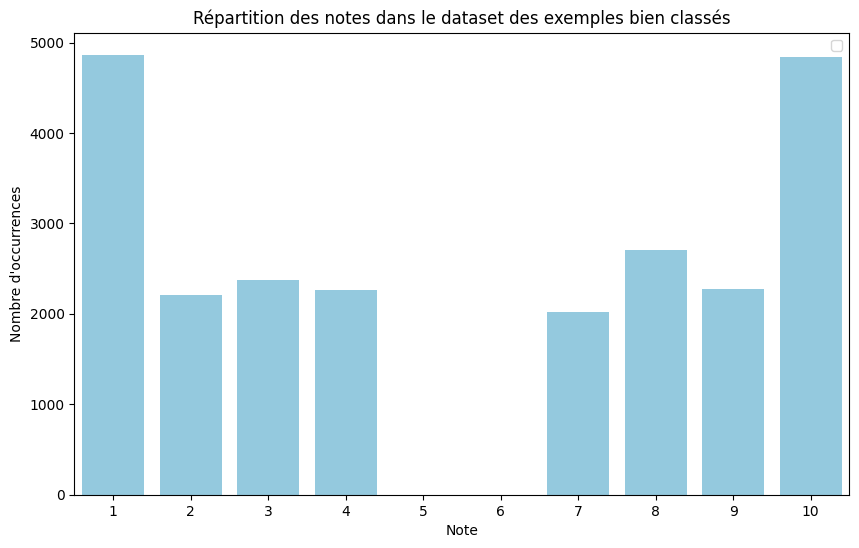

In [45]:
# Répartition des ratings des exemples bien classés
plt.figure(figsize=(10, 6))
sns.countplot(x="rating", data=correct_df, color="skyblue", order=range(1, 11))

plt.xlabel("Note")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des notes dans le dataset des exemples bien classés")
plt.legend()
plt.show()

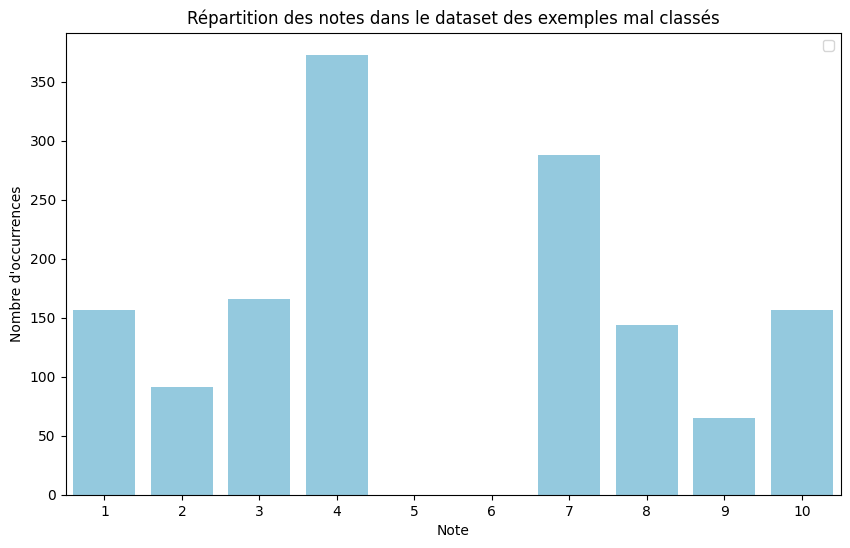

In [46]:
# Répartition des ratings des exemples bien classés
plt.figure(figsize=(10, 6))
sns.countplot(x="rating", data=incorrect_df, color="skyblue", order=range(1, 11))

plt.xlabel("Note")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des notes dans le dataset des exemples mal classés")
plt.legend()
plt.show()

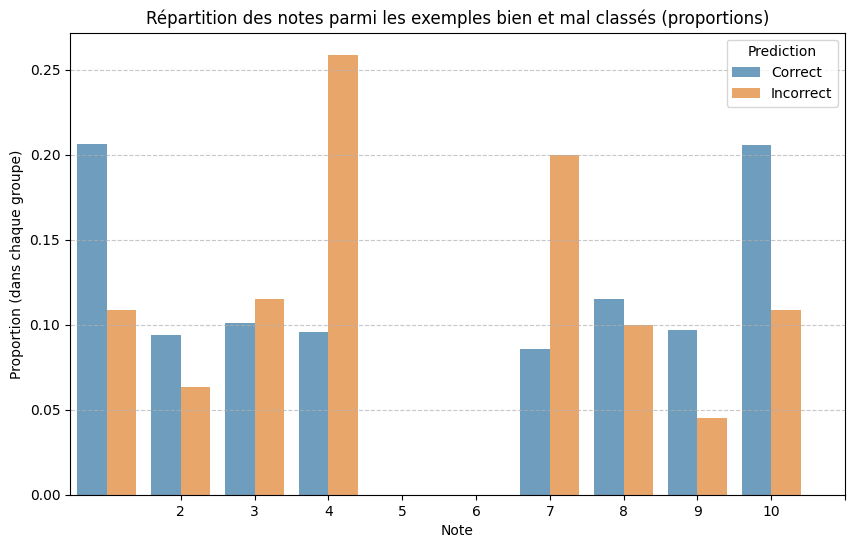

In [47]:
# La même chose en proportions sur le même graph
import seaborn as sns

# Create masks
correct_df = scored_df[scored_df["true_label"] == scored_df["predicted_label"]]
incorrect_df = scored_df[scored_df["true_label"] != scored_df["predicted_label"]]

# Compute normalized counts
correct_counts = correct_df["rating"].value_counts(normalize=True).sort_index()
incorrect_counts = incorrect_df["rating"].value_counts(normalize=True).sort_index()

# Put into a DataFrame for plotting
plot_df = pd.DataFrame({
    "rating": range(1, 11),
    "Correct": correct_counts.reindex(range(1, 11), fill_value=0),
    "Incorrect": incorrect_counts.reindex(range(1, 11), fill_value=0)
})

# Melt for seaborn
plot_df = plot_df.melt(id_vars="rating", value_vars=["Correct", "Incorrect"], var_name="Prediction", value_name="Proportion")

# Now plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="rating",
    y="Proportion",
    hue="Prediction",
    alpha=0.7
)

plt.xlabel("Note")
plt.ylabel("Proportion (dans chaque groupe)")
plt.title("Répartition des notes parmi les exemples bien et mal classés (proportions)")
plt.xticks(ticks=range(1, 11))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Prediction")
plt.show()


In [ ]:
# il faut probablement : 
# 1) examiner les reviews mal classées aux notes extrêmes (1 et 10) : que s'est-il passé ?
# 2) voir comment améliorer la situation pour les notes moyennes... est-ce que créer une catégorie neutre améliorera le modèle ? est-ce pertinent sur ces données ? 